In [55]:
import pandas as pd
import numpy as np
import os
from PIL import Image
from matplotlib import pyplot as plt
import torchvision
from torchvision import datasets, models, transforms
from torch import nn
import torch
from torch.utils.data import Dataset, DataLoader
import re

In [56]:
homepath = os.getcwd()

In [57]:
print(homepath)

/Users/anujjain/Desktop/Side_Project/Flicker8_imageCaption


In [58]:
img = Image.open(homepath + '/Images/972381743_5677b420ab.jpg')

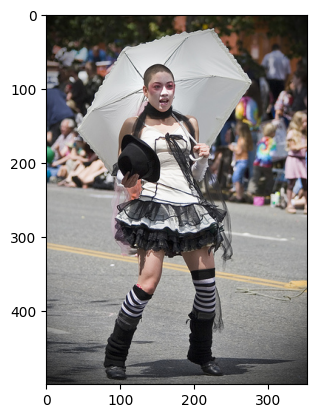

In [59]:
plt.imshow(img)

In [60]:
img.size

(353, 500)

In [61]:
type(img)

PIL.JpegImagePlugin.JpegImageFile

<h3>Resnet34 Image extraction </h3>

In [62]:
class FeatureExtraction(nn.Module):
    def __init__(self):
        super(FeatureExtraction, self).__init__()
        vgg16 = models.resnet34(pretrained = True)
        modules = list(vgg16.children())[:-1]
        self.features = nn.Sequential(*modules)
    
    def forward(self,x):

        with torch.no_grad():
            features = self.features(x)
            
        return features

In [63]:
vgg16_extractor = FeatureExtraction()
# vgg16_extractor.eval()

/Users/anujjain/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/anujjain/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [64]:
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(img)
input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension

features = vgg16_extractor(input_batch)

# Print the extracted features shape
print(features.shape)  

torch.Size([1, 512, 1, 1])


In [65]:
def keep_image_col(file) -> pd.DataFrame:
    df = pd.read_csv(file)
    df = df.drop(['caption'], axis=1)
    df_img = df['image'].unique()
    # pd.DataFrame({'img': df_unig_img['image']})
    df_img = pd.DataFrame({'img': df_img})
    return df_img
    

In [66]:
unique_df = keep_image_col(homepath + '/ImageCaption.csv')

In [67]:
unique_df['img']

0       1000268201_693b08cb0e.jpg
1       1001773457_577c3a7d70.jpg
2       1002674143_1b742ab4b8.jpg
3       1003163366_44323f5815.jpg
4       1007129816_e794419615.jpg
                  ...            
8086     990890291_afc72be141.jpg
8087      99171998_7cc800ceef.jpg
8088      99679241_adc853a5c0.jpg
8089     997338199_7343367d7f.jpg
8090     997722733_0cb5439472.jpg
Name: img, Length: 8091, dtype: object

In [68]:
class CustomDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(homepath + '/Images/' + img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img_path,img


In [69]:
batch_size=8
transform =   transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
        transforms.RandomAffine(degrees=40, translate=None, scale=(1, 2), shear=15),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

image_paths = [img_name for img_name in unique_df['img']]
dataset = CustomDataset(image_paths, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)


In [70]:
def featureMap(unique_df, batch_size=8):
    
    feature_map = {}
    for batch_idx, (img_paths, img_tensors) in enumerate(dataloader):
        features = vgg16_extractor(img_tensors)
        for i, img_name in enumerate(img_paths):
            feature_map[img_name] = features[i]

    return feature_map


In [71]:
# dictt = featureMap(unique_df)

In [72]:
# print(dictt)

In [73]:
# Save the features_map to a file
# torch.save(dictt, homepath+'/resnet34_features_map.pt')

In [74]:
# Load the saved features_map from the file
features_map = torch.load(homepath+'/resnet34_features_map.pt')

<h3> Text Preprocessing </h3>

<h4>below code is generate the clean caption and storing in csv format.</h4>

In [24]:
df = pd.read_csv(homepath + '/ImageCaption.csv')

In [25]:
def cleancaption(caption):
    # -->your code here
     # Remove spaces at the beginning and the end
    caption = caption.strip()
    
    # Convert to lower case
    caption = caption.lower()
    
    # Replace all non-alphabet characters with a space
    caption = re.sub(r'[^a-zA-Z]+', ' ', caption)
    
    # Replace all continuous spaces with a single space
    caption = re.sub(r'\s+', ' ', caption)
    
    return caption

In [26]:
df['clean_caption'] = ""

In [27]:
df['clean_caption'] = df['caption'].apply(cleancaption) 

In [28]:
df.drop(columns = ['caption'],inplace =True)

In [29]:
df.to_csv(homepath+'/clean_caption.csv',index= False)

<h3>Model Prep </h3>

<h4> Data Splitting in Train, Valid, Test </h4>

In [75]:
import random
import math
from collections import Counter
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

In [76]:
df_clean = pd.read_csv(homepath + '/clean_caption.csv')

In [77]:
final_df = df_clean.copy()

In [78]:
final_df

,image,clean_caption
0,1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,a girl going into a wooden building
2,1000268201_693b08cb0e.jpg,a little girl climbing into a wooden playhouse
3,1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,a little girl in a pink dress going into a woo...
...,...,...
40450,997722733_0cb5439472.jpg,a man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,a man is rock climbing high in the air
40452,997722733_0cb5439472.jpg,a person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,a rock climber in a red shirt


In [79]:
def split_ids(image_id_list, train=.7, valid=0.1, test=0.2):
    """
    Args:
        image_id_list (int list): list of unique image ids
        train (float): train split size (between 0 - 1)
        valid (float): valid split size (between 0 - 1)
        test (float): test split size (between 0 - 1)
    """

    # Make a copy of the input list and shuffle it
    list_copy = image_id_list.copy()
    random.shuffle(list_copy)
    
    # Determine the number of images in each split
    train_size = math.floor(len(list_copy) * train)
    valid_size = math.floor(len(list_copy) * valid)

    # Return the splits
    return list_copy[:train_size], list_copy[train_size:(train_size + valid_size)], list_copy[(train_size + valid_size):]

In [80]:
Train_lst, Valid_lst, Test_lst = split_ids(final_df['image'].unique())

In [81]:
print('train Len : ' + str(len(Train_lst)))
print('Validation Len : ' + str(len(Valid_lst)))
print('test Len : ' + str(len(Test_lst)))

train Len : 5663
Validation Len : 809
test Len : 1619


In [82]:
train_set = final_df[final_df['image'].isin(Train_lst)]
valid_set = final_df[final_df['image'].isin(Valid_lst)]
test_set = final_df[final_df['image'].isin(Test_lst)]

In [83]:
print('train Len : ' + str(train_set.shape))
print('Validation Len : ' + str(valid_set.shape))
print('test Len : ' + str(test_set.shape))

train Len : (28315, 2)
Validation Len : (4045, 2)
test Len : (8095, 2)


<h4> Build Vocab</h4>

In [84]:
class Vocabulary(object):
    """ Simple vocabulary wrapper which maps every unique word to an integer ID. """
    def __init__(self):
        # intially, set both the IDs and words to dictionaries with special tokens
        self.word2idx = {'<pad>': 0, '<unk>': 1, '<end>': 2}
        self.idx2word = {0: '<pad>', 1: '<unk>', 2: '<end>'}
        self.idx = 3

    def add_word(self, word):
        # if the word does not already exist in the dictionary, add it
        if not word in self.word2idx:
            # this will convert each word to index and index to word as you saw in the tutorials
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            # increment the ID for the next word
            self.idx += 1

    def __call__(self, word):
        # if we try to access a word not in the dictionary, return the id for <unk>
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)


In [85]:
# [Hint] building a vocab function such with frequent words e.g., setting MIN_FREQUENCY = 3
MIN_FREQUENCY = 3

def build_vocab(df_ids, new_file):
    """ 
    Parses training set token file captions and builds a Vocabulary object and dataframe for 
    the image and caption data

    Returns:
        vocab (Vocabulary): Vocabulary object containing all words appearing more than min_frequency
    """
    word_mapping = Counter()

    # for index in df.index:
    for index, id in enumerate(df_ids):
        caption = str(new_file.loc[new_file['image']==id]['clean_caption'])
        for word in caption.split():
            # also get rid of numbers, symbols etc.
            if word in word_mapping:
                word_mapping[word] += 1
            else:
                word_mapping[word] = 1

    # create a vocab instance
    vocab = Vocabulary()
    # print(type(word_mapping))

    # print(Counter(word_mapping))
    print('Word Mapping size : '+ str(len(word_mapping)))
    # add the words to the vocabulary
    for word, count in word_mapping.items():
        # Ignore infrequent words to reduce the embedding size
        if count > MIN_FREQUENCY:
            vocab.add_word(word)
    return vocab


In [86]:
# build your vocabulary for train, valid and test sets
# ---> your code here!
train_val_dl  = list(Train_lst) + list(Valid_lst)
vocab = build_vocab(train_val_dl, final_df)
# Valid_vocab = build_vocab(Valid_dl, merged_df)

print(len(vocab.word2idx))

Word Mapping size : 41416
3094


In [87]:
# vocab.word2idx

In [88]:
MAX_SEQ_LEN = 47

class Features(Dataset):
    def __init__(self, df, features, vocab):
        self.df = df
        self.features = features
        self.vocab = vocab 
        
    def __getitem__(self,index):
        
        image = self.df.iloc[index]['image']
        clean_caption = self.df.iloc[index]['clean_caption']
        
        img_feature = self.features[image].clone().detach()
        
        token = clean_caption.split()
        target_caption = [self.vocab(i) for i in token]
        target_caption.append(self.vocab('<end>'))

        true_caption_len = len(target_caption)
        
        while len(target_caption) < MAX_SEQ_LEN:
            target_caption.append(self.vocab('<pad>'))
            
        
        target_caption = torch.tensor(target_caption)
        
        
        return img_feature, target_caption, true_caption_len
    
    def __len__(self):
        return len(self.df)
        

In [89]:
def caption_collate_fn(data):
    """ Creates mini-batch tensors from the list of tuples (image, caption).
    Args:
        data: list of tuple (image, caption). 
            - image: torch tensor of shape (3, 224, 224).
            - caption: torch tensor of shape (?); variable length.
    Returns:
        images: torch tensor of shape (batch_size, 3, 224, 224).
        targets: torch tensor of shape (batch_size, padded_length).
        lengths: list; valid length for each padded caption.
    """
    # Sort a data list by caption length from longest to shortest.
    data.sort(key=lambda x: x[2], reverse=True)
    images, captions, lengths = zip(*data)

    # Merge images (from tuple of 3D tensor to 4D tensor).
    # If using features, 2D tensor to 3D tensor (batch_size, 256).
    images = torch.stack(images, 0)

    # Merge captions (from tuple of 1D tensor to 2D tensor).
    targets = torch.stack(captions, 0)

    # Pad with zeros.
    # Since the captions are already padded in the Dataset class, no additional padding is needed here.

    return images, targets, lengths

In [90]:
train_image_ids = set(train_set["image"].unique())
valid_image_ids = set(valid_set["image"].unique())
test_image_ids = set(test_set["image"].unique())

loaded_image_ids = set(features_map.keys())

train_image_ids_filtered = train_image_ids.intersection(loaded_image_ids)
valid_image_ids_filtered = valid_image_ids.intersection(loaded_image_ids)
test_image_ids_filtered = test_image_ids.intersection(loaded_image_ids)

train_df_filtered = train_set[train_set["image"].isin(train_image_ids_filtered)]
valid_df_filtered = valid_set[valid_set["image"].isin(valid_image_ids_filtered)]
test_df_filtered = test_set[test_set["image"].isin(test_image_ids_filtered)]

print("Train_df_filtered length:", len(train_df_filtered))
print("Valid_df_filtered length:", len(valid_df_filtered))
print("Test_df_filtered length:", len(test_df_filtered))

print("Unique image IDs in Train_df_filtered:", len(train_image_ids_filtered))
print("Unique image IDs in Valid_df_filtered:", len(valid_image_ids_filtered))
print("Unique image IDs in Test_df_filtered:", len(test_image_ids_filtered))


Train_df_filtered length: 28315
Valid_df_filtered length: 4045
Test_df_filtered length: 8095
Unique image IDs in Train_df_filtered: 5663
Unique image IDs in Valid_df_filtered: 809
Unique image IDs in Test_df_filtered: 1619


<h4>Creating Dataset and Dataloader</h4>

In [91]:
train_dataset = Features(
    df = train_df_filtered,
    features = features_map,
    vocab = vocab)

train_dataloder = DataLoader(
    dataset=train_dataset,
    batch_size=8,
    shuffle=True,
    collate_fn=caption_collate_fn,
)


valid_dataset = Features(
    df = valid_df_filtered,
    features = features_map,
    vocab = vocab)

valid_dataloder = DataLoader(
    dataset=valid_dataset,
    batch_size=8,
    shuffle=True,
    collate_fn=caption_collate_fn,
)


test_dataset = Features(
    df = test_df_filtered,
    features = features_map,
    vocab = vocab)

test_dataloder = DataLoader(
    dataset=test_dataset,
    batch_size=8,
    shuffle=True,
    collate_fn=caption_collate_fn,
)


In [92]:
print("Length of training dataset:", len(train_dataset))
print("Length of training dataframe:", len(train_df_filtered))
print("Length of validation dataset:", len(valid_dataset))
print("Length of validation dataframe:", len(valid_df_filtered))


Length of training dataset: 28315
Length of training dataframe: 28315
Length of validation dataset: 4045
Length of validation dataframe: 4045


In [93]:
# Create an iterator for the training DataLoader
iterator_train = iter(train_dataloder)
print(type(iterator_train))

# Fetch the first batch from the iterator
images_batch, captions_batch, lengths_batch = next(iterator_train)

print(f"Image features batch shape: {images_batch.shape}")
print(f"Captions batch shape: {captions_batch.shape}")
print(f"Lengths: {lengths_batch}")

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>
Image features batch shape: torch.Size([8, 512, 1, 1])
Captions batch shape: torch.Size([8, 47])
Lengths: (16, 14, 14, 14, 13, 9, 9, 8)


In [94]:
class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)
        self.full_att = nn.Linear(attention_dim, 1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        self.enc_att = nn.Linear(encoder_dim, attention_dim)

    def forward(self, encoder_out, decoder_hidden):
        att1 = self.encoder_att(encoder_out)
        att2 = self.decoder_att(decoder_hidden)
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)
        alpha = self.softmax(att)
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)
        return attention_weighted_encoding, alpha


In [121]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_size=256, hidden_size=512, num_layers=1, max_seq_length=47):
        """Set the hyper-parameters and build the layers."""
        super(Decoder, self).__init__()
        self.resize = nn.Linear(512, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, hidden_size, num_layers, batch_first=True, dropout=0.5)
        
        self.linear = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_size, vocab_size)
        )
        
        # # Dropout layer to regularize the model and prevent overfitting
        self.dropout = nn.Dropout(p=0.5)
        
        self.max_seq_length = max_seq_length
        # Attention mechanism
        self.attention = Attention(embed_size, hidden_size, 512)
        # Initialize the weights of the linear layers
        nn.init.xavier_uniform_(self.resize.weight)
        # # Index 3 to initialize the last linear layer
        nn.init.xavier_uniform_(self.linear[3].weight)
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        # print(features.shape)
        features = features.view(features.size(0), -1)
        im_features = self.resize(features)
        # print(im_features.shape)
        # im_features = self.bn(im_features).unsqueeze(1)
       
        hidden_state = torch.zeros(features.size(0), self.rnn.hidden_size).to(features.device)
        context_vector, _ = self.attention(im_features.unsqueeze(1), hidden_state)
        context_vector = context_vector.unsqueeze(1)

        # Concatenate context vector and embeddings
        embeddings = torch.cat((context_vector, embeddings), dim=1)
        
        # pack_padded_sequence returns a PackedSequence object, which contains two items: 
        # the packed data (data cut off at its true length and flattened into one list), and 
        # the batch_sizes, or the number of elements at each sequence step in the batch.
        # For instance, given data [a, b, c] and [x] the PackedSequence would contain data 
        # [a, x, b, c] with batch_sizes=[2,1,1].

        # Pack the sequence of embeddings to process them in the LSTM
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True)
        
        # Pass the packed sequence through the LSTM
        hiddens, _ = self.rnn(packed)
        outputs = self.linear(hiddens[0])
        return outputs
    
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []

        inputs = self.bn(self.resize(features)).unsqueeze(1)
        for i in range(self.max_seq_length):
            hiddens, states = self.rnn(inputs, states)  # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))   # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)               # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)              # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)       # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

In [122]:
decoder = Decoder(len(vocab))

In [123]:
decoder

Decoder(
  (resize): Linear(in_features=512, out_features=256, bias=True)
  (bn): BatchNorm1d(256, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (embed): Embedding(3094, 256)
  (rnn): GRU(256, 512, batch_first=True, dropout=0.5)
  (linear): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=3094, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (attention): Attention(
    (encoder_att): Linear(in_features=256, out_features=512, bias=True)
    (decoder_att): Linear(in_features=512, out_features=512, bias=True)
    (full_att): Linear(in_features=512, out_features=1, bias=True)
    (relu): ReLU()
    (softmax): Softmax(dim=1)
    (enc_att): Linear(in_features=256, out_features=512, bias=True)
  )
)

In [124]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        # print(validation_loss)
        # print(self.min_validation_loss)
        # print(self.min_delta)
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered.")
                return True
        return False

In [125]:
num_epochs = 20
batch_size = 8
learning_rate = 0.0001
weight_decay = 1e-5# L2 regularization parameter

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RAdam(decoder.parameters(), lr=learning_rate, weight_decay=weight_decay)
decoder.train()  # switch to training mode

train_loss_list = []
val_loss_list = []

early_stopper = EarlyStopper(patience=3, min_delta=0.4)
for epoch in range(num_epochs):
    train_loss = 0
    val_loss = 0
    
    # Training loop
    for i, (images, captions, lengths) in enumerate(train_dataloder):
        decoder.zero_grad()
        outputs = decoder(images, captions, lengths)
        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # Validation loop
    with torch.no_grad():
        for i, (images, captions, lengths) in enumerate(valid_dataloder):
            outputs = decoder(images, captions, lengths)
            targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    train_loss /= len(train_dataloder)
    val_loss /= len(valid_dataloder)
    
    if early_stopper.early_stop(val_loss):             
        break

    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    
    print(f"Epoch [{epoch}/{num_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

Epoch [0/20], Training Loss: 4.4175, Validation Loss: 3.7610
Epoch [1/20], Training Loss: 3.5509, Validation Loss: 3.4398
Epoch [2/20], Training Loss: 3.2883, Validation Loss: 3.2845
Epoch [3/20], Training Loss: 3.1250, Validation Loss: 3.1933
Epoch [4/20], Training Loss: 3.0032, Validation Loss: 3.1361
Epoch [5/20], Training Loss: 2.9078, Validation Loss: 3.0918
Epoch [6/20], Training Loss: 2.8279, Validation Loss: 3.0595
Epoch [7/20], Training Loss: 2.7575, Validation Loss: 3.0515
Epoch [8/20], Training Loss: 2.6936, Validation Loss: 3.0365
Epoch [9/20], Training Loss: 2.6350, Validation Loss: 3.0393
Epoch [10/20], Training Loss: 2.5786, Validation Loss: 3.0394
Epoch [11/20], Training Loss: 2.5243, Validation Loss: 3.0474
Epoch [12/20], Training Loss: 2.4721, Validation Loss: 3.0437
Epoch [13/20], Training Loss: 2.4231, Validation Loss: 3.0719
Epoch [14/20], Training Loss: 2.3716, Validation Loss: 3.0830
Epoch [15/20], Training Loss: 2.3248, Validation Loss: 3.1221
Epoch [16/20], Tra

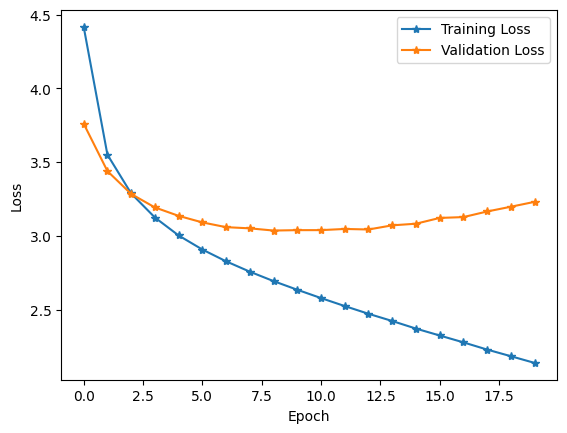

In [126]:
# Plot the loss curves after all epochs
plt.plot(train_loss_list, label="Training Loss", marker = '*')
plt.plot(val_loss_list, label="Validation Loss",marker = '*')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

<h4> Generate Caption </h4>

In [128]:
def generate_caption(image_tensor, decoder, vocab):
    """Generate a caption for the given image using the trained decoder."""
    # Set the decoder to evaluation mode
    decoder.eval()
    
    # Add a batch dimension to the image tensor and move it to the device
    # image_tensor = image_tensor.unsqueeze(0).to(device)
    
    # Initialize the hidden and cell states for the decoder
    with torch.no_grad():
        hidden = decoder.init_hidden(1)
        cell = decoder.init_cell(1)
        
        # Initialize the predicted_ids list with the <start> token ID
        predicted_ids = [vocab('<start>')]
        caption = []

        # Generate the caption one word at a time
        while True:
            # Convert the last predicted ID to a tensor and move it to the device
            inputs = torch.tensor(predicted_ids[-1]).unsqueeze(0).to(device)
            
            # Pass the input, hidden state, cell state, and image through the decoder
            outputs, hidden, cell = decoder(inputs, hidden, cell, image_tensor)
            
            # Choose the word ID with the highest probability
            predicted_id = outputs.argmax(dim=1).item()

            # Stop the generation if the end token is predicted or the caption is too long
            if vocab.idx2word[predicted_id] == '<end>' or len(caption) >= MAX_SEQ_LEN:
                break
            
            # Append the predicted word to the caption and predicted_ids list
            caption.append(vocab.idx2word[predicted_id])
            predicted_ids.append(predicted_id)
    
    # Join the predicted words into a single string and return it
    return ' '.join(caption)


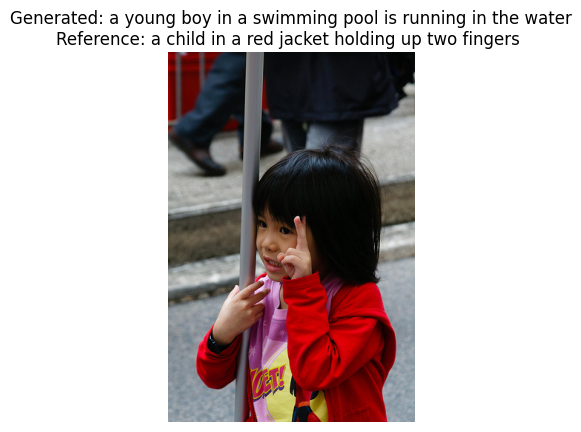

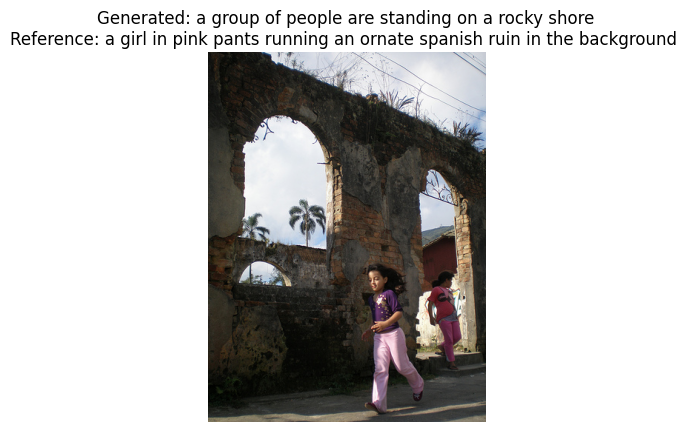

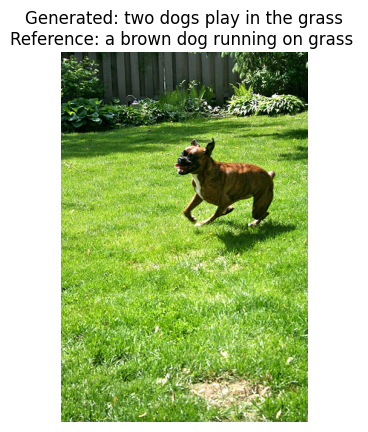

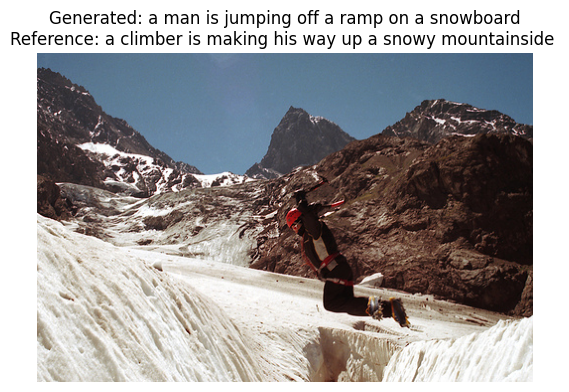

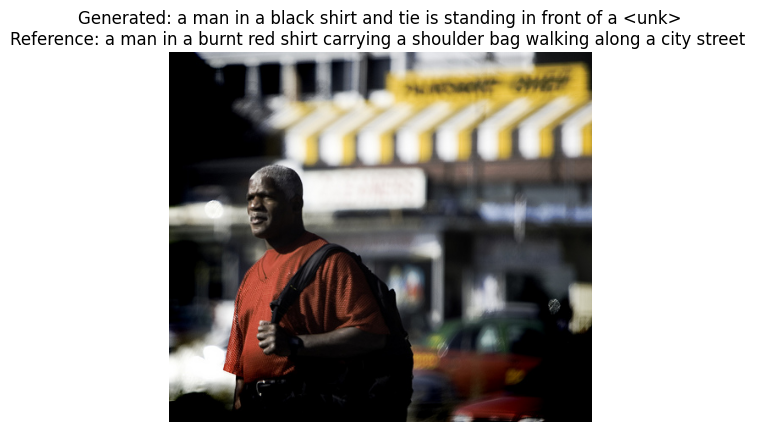

In [129]:
import random
import matplotlib.pyplot as plt
from PIL import Image

def display_image_with_captions(image_path, caption, reference_captions):
    img = Image.open(image_path)
    plt.imshow(img)
    plt.title(f"Generated: {caption}\nReference: {reference_captions}")
    plt.axis("off")
    plt.show()


decoder.eval()

# Number of images to display
num_images = 5

for _ in range(num_images):
    random_image_id = random.choice(test_df_filtered["image"].unique())
    # print(random_image_id)
    selected_image = test_df_filtered[test_df_filtered["image"] == random_image_id].iloc[0]
    # print(selected_image)
    image_path = homepath+'/images/' + random_image_id
    # print(image_path)
    
    image_features = features_map[random_image_id]
    # print(image_features.shape)
    image_features = image_features.unsqueeze(0)
    image_features = image_features.view(image_features.size(0), -1)
    # print(image_features.shape)
    
    # Generate captions
    with torch.no_grad():
        
        generated_caption = decoder.sample(image_features)
    
    # Convert caption tokens to words
    caption_words = []
    for token in generated_caption.squeeze(0):
        word = vocab.idx2word[token.item()]
        if word == '<end>':
            break
        caption_words.append(word)
    caption = ' '.join(caption_words)
    
    # Get reference captions
    reference_captions = test_df_filtered[test_df_filtered["image"] == random_image_id]["clean_caption"].tolist()
    
    # Display the image with generated and reference captions
    display_image_with_captions(image_path, caption, reference_captions[0])
    

Average BLEU score on all test data: 0.003942919942162734


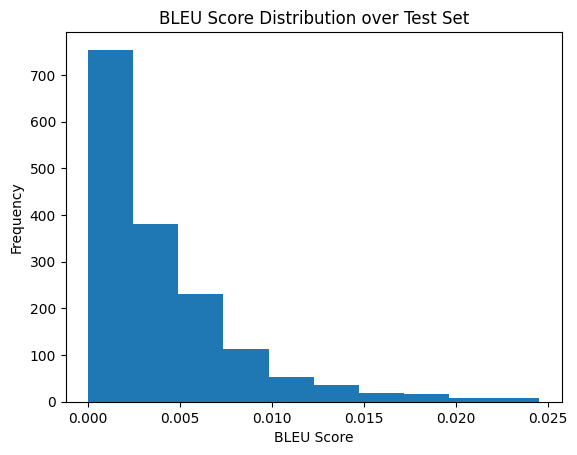

Stats DataFrame:
                                                 ref  \
0  [a child in a pink dress is climbing up a set ...   
1  [a little girl covered in paint sits in front ...   
2  [a dog shakes its head near the shore a red ba...   
3  [a man in a hat is displaying pictures next to...   
4  [a black dog running in the surf , a black lab...   

                                               preds      bleu  
0  a man is sitting on a bench in front of a buil...  0.003570  
1     a girl in a pink shirt is sliding down a slide  0.000521  
2  a black dog and a brown dog are standing in th...  0.000475  
3  a woman in a black shirt is walking on a sidewalk  0.000749  
4                   a <unk> car is <unk> in the snow  0.002660  


In [142]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import numpy as np
import matplotlib.pyplot as plt

# Initialize BLEU score list and stats DataFrame
bleu_scores = []
stats = pd.DataFrame(columns=['ref', 'preds', 'bleu'])

# Loop through the test dataset
for image_id in test_df_filtered["image"].unique():
    selected_image = test_df_filtered[test_df_filtered["image"] == image_id].iloc[0]
    image_features = features_map[image_id].unsqueeze(0)
    image_features = image_features.view(image_features.size(0), -1)
    
    # Generate captions
    with torch.no_grad():
        generated_caption = decoder.sample(image_features)
    
    # Convert caption tokens to words
    caption_words = []
    for token in generated_caption.squeeze(0):
        word = vocab.idx2word[token.item()]
        if word == '<end>':
            break
        caption_words.append(word)
    generated_caption_text = ' '.join(caption_words)
    
    # Get reference captions
    reference_captions = test_df_filtered[test_df_filtered["image"] == image_id]["clean_caption"].tolist()
    
    # Calculate BLEU score
    smoothing = SmoothingFunction().method4
    bleu_score = sentence_bleu(reference_captions, generated_caption_text.split(), smoothing_function=smoothing)
    bleu_scores.append(bleu_score)
    
    # Add reference captions, predicted caption, and BLEU score to stats DataFrame
    new_row = pd.DataFrame({
        'ref': [reference_captions],
        'preds': [generated_caption_text],
        'bleu': [bleu_score],
    })
    stats = pd.concat([stats, new_row], ignore_index=True)

# Calculate and display average BLEU score
average_bleu_score = np.mean(bleu_scores)
print(f"Average BLEU score on all test data: {average_bleu_score}")

# Display histogram of BLEU score distribution
plt.hist(bleu_scores, bins=10)
plt.xlabel('BLEU Score')
plt.ylabel('Frequency')
plt.title('BLEU Score Distribution over Test Set')
plt.show()

print("Stats DataFrame:")
print(stats.head())


In [143]:
# TO COMPLETE
# Convert 'bleu' column to a numeric dtype (e.g., float)
stats['bleu'] = stats['bleu'].astype(float)

# Find the indices of the highest and lowest BLEU scores
highest_bleu_idx = stats['bleu'].idxmax()
lowest_bleu_idx = stats['bleu'].idxmin()

# Display the highest BLEU score sample
print("Sample with the highest BLEU score:")
print(f"Predicted caption: {stats.iloc[highest_bleu_idx]['preds']}")
print(f"Reference captions: {stats.iloc[highest_bleu_idx]['ref']}")
print(f"BLEU score: {stats.iloc[highest_bleu_idx]['bleu']}")

print("\n")

# Display the lowest BLEU score sample
print("Sample with the lowest BLEU score:")
print(f"Predicted caption: {stats.iloc[lowest_bleu_idx]['preds']}")
print(f"Reference captions: {stats.iloc[lowest_bleu_idx]['ref']}")
print(f"BLEU score: {stats.iloc[lowest_bleu_idx]['bleu']}")

Sample with the highest BLEU score:
Predicted caption: a man in a red shirt is riding a bike on a track
Reference captions: ['a biker races ', 'a guy on a bmx bike ', 'a man rides a bike through a course ', 'stop action frame of a racer in a bicycle race ', 'the bike rider is wearing a silver helmet and red shirt ']
BLEU score: 0.024519691881314084


Sample with the lowest BLEU score:
Predicted caption: two dogs are playing in the snow
Reference captions: ['a black dog retrieves a cloth from a streambed ', 'a dog drags a white rag through an almost dried up creek ', 'a dog is wading in a river with a towel in its mouth ', 'a dog walking through a small stream with a rag in his mouth ', 'a dog walking through a stream carrying a white towel in its mouth']
BLEU score: 0.0


In [140]:
# Save the trained model 
torch.save(decoder.state_dict(), homepath + '/resnet34FlickerModel.ckpt')